### **Project: Clustering Analysis of Football Players Using Transfermarkt Data**

Submitted by:
Ergys Meda

Student ID: 2071547

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
 

/kaggle/input/players.csv
/kaggle/input/competitions.csv
/kaggle/input/games.csv
/kaggle/input/game_events.csv
/kaggle/input/club_games.csv
/kaggle/input/player_valuations.csv
/kaggle/input/game_lineups.csv
/kaggle/input/appearances.csv
/kaggle/input/clubs.csv


In [3]:
## Data Exploration and Preprocessing

### Import Libraries 
import pandas as pd
import numpy as np
import networkx as nx 


In [8]:
# Load the Transfermarkt dataset
appearances = pd.read_csv('/kaggle/input/appearances.csv')
club_games = pd.read_csv('/kaggle/input/club_games.csv')
clubs = pd.read_csv('/kaggle/input/clubs.csv')
competitions = pd.read_csv('/kaggle/input/competitions.csv')
game_events = pd.read_csv('/kaggle/input/game_events.csv')
game_lineups = pd.read_csv('/kaggle/input/game_lineups.csv')
games = pd.read_csv('/kaggle/input/games.csv')
player_valuations = pd.read_csv('/kaggle/input/player_valuations.csv')
players = pd.read_csv('/kaggle/input/players.csv') 
 

In [10]:
def check_df(dataframe, head=5):
    print("#################### Info #######################")
    print(dataframe.info())
    print("#################### Shape #######################")
    print(dataframe.shape)
    print("#################### Types #######################")
    print(dataframe.dtypes)
    print("#################### Head #######################")
    print(dataframe.head(head))
    print("#################### Tail #######################")
    print(dataframe.tail(head))
    print("#################### Null #######################")
    print(dataframe.isnull().sum())
    print("#################### Describe #######################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("#################### NUNIQUE #######################")
    print(dataframe.nunique())

In [58]:
# Study and normalize relevant features in the 'appearances' dataframe
check_df(appearances)

# Normalize the 'market_value_in_eur' column in the 'player_valuations' dataframe
player_valuations['market_value_in_eur'] = player_valuations['market_value_in_eur'] / player_valuations['market_value_in_eur'].max()
# Check the dataframe after normalization
check_df(player_valuations)

# Normalize 'highest_market_value_in_eur' and 'market_value_in_eur' columns in the 'players' dataframe
players['highest_market_value_in_eur'] = players['highest_market_value_in_eur'] / players['highest_market_value_in_eur'].max()
players['market_value_in_eur'] = players['market_value_in_eur'] / players['market_value_in_eur'].max()
# Check the dataframe after normalization
check_df(players)


#################### Info #######################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1524941 entries, 0 to 1524940
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   appearance_id           1524941 non-null  object
 1   game_id                 1524941 non-null  int64 
 2   player_id               1524941 non-null  int64 
 3   player_club_id          1524941 non-null  int64 
 4   player_current_club_id  1524941 non-null  int64 
 5   date                    1524941 non-null  object
 6   player_name             1524940 non-null  object
 7   competition_id          1524941 non-null  object
 8   yellow_cards            1524941 non-null  int64 
 9   red_cards               1524941 non-null  int64 
 10  goals                   1524941 non-null  int64 
 11  assists                 1524941 non-null  int64 
 12  minutes_played          1524941 non-null  int64 
dtypes: int64(9), object(4)

In [59]:
league_weights = {
    'IT1': 1.2,   # Serie A
    'NL1': 1.1,   # Eredivisie
    'GR1': 1.0,   # Super League Greece
    'PO1': 1.0,   # Primeira Liga
    'RU1': 1.2,   # Russian Premier League
    'ES1': 1.3,   # La Liga
    'DK1': 1.0,   # Danish Superliga
    'FR1': 1.2,   # Ligue 1
    'BE1': 1.1,   # Belgian Pro League
    'GB1': 1.3,   # English Premier League
    'UKR1': 1.0,  # Ukrainian Premier League
    'TR1': 1.0,   # Süper Lig
    'L1': 1.0,    # Bundesliga
    'SC1': 1.0    # Scottish Premiership
}


In [60]:
# Strikers

# Create parameters for evaluating similarity between players
appearances_agg = appearances.groupby('player_id').agg({
    'yellow_cards': 'sum', 'red_cards': 'sum',
    'goals': 'sum', 'assists': 'sum',
    'minutes_played': 'sum',
}).reset_index()

appearances_agg['matches'] = appearances.groupby('player_id').size().reset_index(name='matches')['matches']

# Define desired sub-positions and preferred foot
desired_sub_positions = ['Centre-Forward', 'Second Striker', 'Left Winger', 'Right Winger']
desired_foot = ['left', 'right', 'both']

# Filter players based on sub-positions and preferred foot
filtered_players = players[players['sub_position'].isin(desired_sub_positions)]
filtered_players = filtered_players[filtered_players['foot'].isin(desired_foot)]

# Merge aggregated statistics with the 'players' dataframe
players_merged = pd.merge(filtered_players, appearances_agg, on='player_id')

# Calculate additional metrics
players_merged['goals_per_match'] = players_merged['goals'] / players_merged['matches']
players_merged['assists_per_match'] = players_merged['assists'] / players_merged['matches']
players_merged['date_of_birth'] = pd.to_datetime(players_merged['date_of_birth'])
players_merged['age'] = round((pd.to_datetime('2023-01-01') - players_merged['date_of_birth']).dt.days / 365)
players_merged['league_weight'] = players_merged['current_club_domestic_competition_id'].map(league_weights)
players_merged['foot_bonus'] = players_merged['foot'].apply(lambda x: 1.1 if isinstance(x, str) and x.lower() == 'both' else 1.0)

# Normalize selected features
selected_features = ['goals_per_match', 'assists_per_match', 'height_in_cm', 'age', 'matches', 'league_weight', 'foot_bonus']
for feature in selected_features:
    players_merged[feature] = players_merged[feature] / players_merged[feature].max()

# Create a composite performance score ('SKORE') in the 'players' DataFrame
players_merged['SKORE'] = (
    players_merged['goals_per_match'] * 0.35 +
    players_merged['assists_per_match'] * 0.15 +
    players_merged['height_in_cm'] * 0.05 +
    players_merged['matches'] * 0.15 +
    players_merged['market_value_in_eur'] * 0.1 +
    players_merged['highest_market_value_in_eur'] * 0.1 +
    players_merged['league_weight'] * 0.10 +
    players_merged['foot_bonus'] * 0.10
)

# Define desired fields for the final dataframe
desired_fields = ['first_name', 'last_name', 'foot_bonus', 'player_id', 'goals', 'assists', 'matches',
                  'market_value_in_eur', 'SKORE', 'foot', 'league_weight', 'matches',
                  'current_club_domestic_competition_id', 'age', 'sub_position', 'goals_per_match',
                  'height_in_cm', 'assists_per_match']

# Select desired fields in the final dataframe
players_merged = players_merged[desired_fields]

# Display the top 20 ranked players based on 'SKORE'
top_20_strikers = players_merged.sort_values(by='SKORE', ascending=False).head(20)
import plotly.express as px

# Create a horizontal bar chart for visualization
top_20_strikers_g = px.bar(top_20_strikers, x='SKORE', y='last_name', orientation='h', title='Top 20 Strikers', text="SKORE")
top_20_strikers_g.show()

# Display the top 20 strikers dataframe
top_20_strikers

,first_name,last_name,foot_bonus,player_id,goals,assists,matches,market_value_in_eur,SKORE,foot,league_weight,matches,current_club_domestic_competition_id,age,sub_position,goals_per_match,height_in_cm,assists_per_match
4948,Erling,Haaland,0.909091,418560,165,38,0.311355,1.000000,0.848642,left,1.000000,0.311355,GB1,0.448980,Centre-Forward,0.970588,0.955882,0.223529
436,Lionel,Messi,0.909091,28003,443,219,0.937729,0.194444,0.841979,left,0.923077,0.937729,FR1,0.734694,Right Winger,0.865234,0.833333,0.427734
4346,Kylian,Mbappé,0.909091,342229,228,97,0.560440,1.000000,0.819244,right,0.923077,0.560440,FR1,0.489796,Left Winger,0.745098,0.872549,0.316993
145,NaN,Cristiano Ronaldo,0.909091,8198,432,114,0.882784,0.083333,0.786663,right,1.000000,0.882784,GB1,0.775510,Centre-Forward,0.896266,0.916667,0.236515
673,Robert,Lewandowski,0.909091,38253,454,111,1.000000,0.111111,0.763883,right,1.000000,1.000000,ES1,0.693878,Centre-Forward,0.831502,0.906863,0.203297
2185,Harry,Kane,0.909091,132098,294,69,0.794872,0.611111,0.730197,right,0.769231,0.794872,L1,0.591837,Centre-Forward,0.677419,0.921569,0.158986
1339,NaN,Neymar,0.909091,68290,212,143,0.626374,0.277778,0.717521,right,0.923077,0.626374,FR1,0.632653,Left Winger,0.619883,0.857843,0.418129
2349,NaN,Mohamed Salah,0.909091,148455,254,117,0.851648,0.361111,0.701584,left,1.000000,0.851648,GB1,0.632653,Right Winger,0.546237,0.857843,0.251613
790,Luis,Suárez,0.909091,44352,283,146,0.796703,0.022222,0.680291,right,1.000000,0.796703,ES1,0.734694,Centre-Forward,0.650575,0.892157,0.335632
2091,Antoine,Griezmann,0.909091,125781,213,100,0.913919,0.138889,0.639482,left,1.000000,0.913919,ES1,0.653061,Centre-Forward,0.426854,0.862745,0.200401


In [62]:
import sys

# Define a similarity function for SKORE values
def similarity_function(skore1, skore2):
    """
    Calculate the similarity between two SKORE values.

    Parameters:
    - skore1 (float): SKORE value for the first player.
    - skore2 (float): SKORE value for the second player.

    Returns:
    - similarity (float): A measure of similarity between SKORE values.
    """

    # Calculate the absolute difference between SKORE values
    diff = abs(skore1 - skore2)
    if diff == 0:
        return 0.00001 
    return diff 


In [63]:
import networkx as nx
import community
import matplotlib.pyplot as plt
import warnings

# Ignore UserWarnings to enhance readability
warnings.filterwarnings("ignore", category=UserWarning)

# Get only the top 700 strikers based on 'SKORE'
top_700_strikers = players_merged.sort_values(by='SKORE', ascending=False).head(700)

# Create an undirected graph
G = nx.Graph()

# Iterate through pairs of players and create edges based on similarity
for i, player1 in top_700_strikers.iterrows():
    for j, player2 in top_700_strikers.iterrows():
        if i < j:
            # Calculate similarity using the previously defined function
            similarity = similarity_function(player1['SKORE'], player2['SKORE'])
            
            # Consider only strong similarities (adjust threshold as needed)
            if similarity < 0.005:
                # Get player names
                node1_label = f"{player1['first_name']} {player1['last_name']}"
                node2_label = f"{player2['first_name']} {player2['last_name']}"
                
                # Add nodes if not already present
                for node_label, player in [(node1_label, player1), (node2_label, player2)]:
                    if node_label not in G:
                        G.add_node(node_label, player_id=player['player_id'])
                    G.nodes[node_label].update(player.to_dict())
                
                # Add edge with player IDs and additional data
                G.add_edge(node1_label, node2_label, weight=similarity)

# Save the initial state of the graph for future reference
G_beginning = G


In [64]:
print(sys.maxsize)
print('\nSize of graph, i.e. number of edges:', G.size())

9223372036854775807

Size of graph, i.e. number of edges: 19736


In [65]:
def display_networks(G, pos, partition):
    """
    Display different visualizations of the network graph.

    Parameters:
    - G (networkx.Graph): The network graph.
    - pos (dict): The node positions in the graph.
    - partition (dict): A dictionary mapping node IDs to community assignments.

    Returns:
    - None
    """
    
    # Visualization with nodes, edges, and labels
    nodes = nx.draw_networkx_nodes(G, pos, node_size=100, cmap=plt.cm.plasma, 
                                   node_color=list(partition.values())) 
    labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)

    plt.title('Full Graph')
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

    # Visualization with nodes only (no edges)
    nodes = nx.draw_networkx_nodes(G, pos, node_size=10, cmap=plt.cm.plasma,
                                   node_color=list(partition.values()))
    labels = nx.draw_networkx_labels(G, pos)
    plt.title('Graph without Edges')
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

    # Visualization with nodes and edges (no labels)
    nodes = nx.draw_networkx_nodes(G, pos, node_size=10, cmap=plt.cm.plasma, 
                                   node_color=list(partition.values()))  
    edges = nx.draw_networkx_edges(G, pos)

    plt.title('Graph without Labels')
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

    # Visualization with nodes only (no edges, no labels)
    nodes = nx.draw_networkx_nodes(G, pos, node_size=10, cmap=plt.cm.plasma,
                                   node_color=list(partition.values())) 
    plt.title('Graph without Edges and Labels')
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()


Modularity:  0.6011203869044549


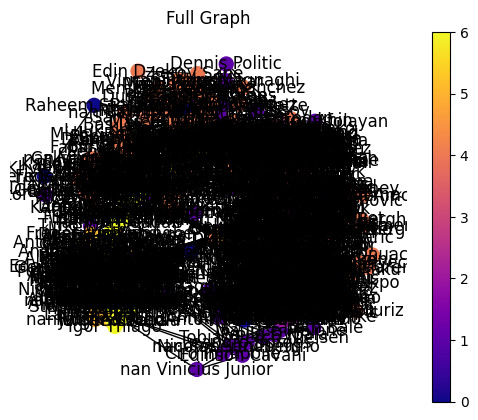

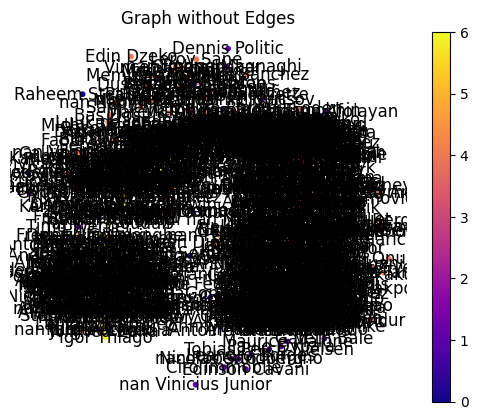

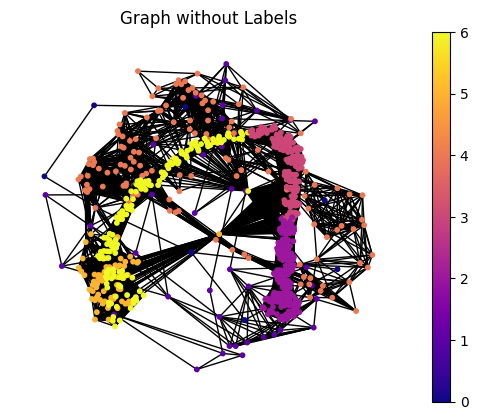

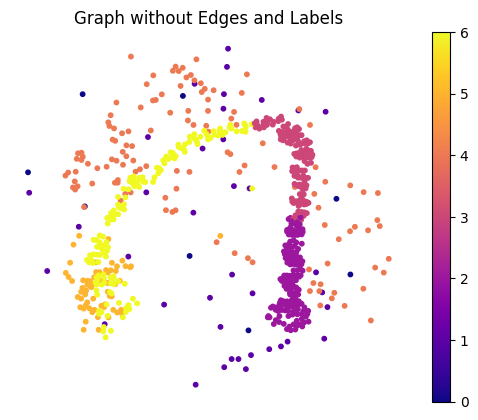

In [66]:
# Apply Louvain method considering weighted edges 
partition = community.best_partition(G, weight='weight', resolution=1)
modularity_score = community.modularity(partition, G)

# Print the modularity score obtained from the Louvain method
print('Modularity: ', modularity_score)

# Add community information to the nodes in the graph
for node, community_id in partition.items():
    G.nodes[node]['community'] = community_id

# Generate a layout for the nodes using the spring layout algorithm
pos = nx.spring_layout(G)

# Display different visualizations of the network graph based on Louvain communities
display_networks(G, pos, partition)


In [67]:
# Calculate coverage 

# Create a dictionary to store nodes belonging to each community
community_sets = {}

# Populate the dictionary with nodes belonging to each community
for node, community_id in partition.items():
    if community_id not in community_sets:
        community_sets[community_id] = set()
    community_sets[community_id].add(node)

# Calculate the union set of all nodes across communities
union_set = set().union(*community_sets.values())

# Calculate coverage as the ratio of the union set size to the total number of nodes in the graph
coverage_value = len(union_set) / len(G.nodes)

# Print the coverage value
print('Coverage:', coverage_value)


Coverage: 1.0


In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

# Initialize an empty feature matrix
feature_matrix = []

# Populate the feature matrix with SKORE values for each node in the graph
for node in G.nodes:
    feature_vector = [G.nodes[node]['SKORE']]
    feature_matrix.append(feature_vector)

# Standardize the feature matrix
scaler = StandardScaler()
feature_matrix_standardized = scaler.fit_transform(feature_matrix)
 
cluster_labels = list(partition.values())

# Calculate silhouette score
silhouette_avg = silhouette_score(feature_matrix_standardized, cluster_labels)

# Print the calculated silhouette score
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.4929837073268156


In [69]:
# Initialize dictionaries to store community centers and communities
centers = {}
communities = {}

# Create a copy of the original graph to retain the main community structure
G_main_com = G.copy()
 

# Iterate through unique community labels
for com in set(partition.values()):
    # Identify nodes belonging to the current community
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
     
     # Get the center of the community using degree centrality
    H = G_main_com.subgraph(list_nodes)
    d_c = nx.degree_centrality(H)
    center = max(d_c, key=d_c.get)
        
    # Store the center and community information in dictionaries
    centers[center] = com
    communities[com] = center
        
    # Print information about the community
    print('Community of', center, '(ID', com, ') -', len(list_nodes), 'authors:')
    print(list_nodes, '\n')


Community of Sergio Agüero (ID 0 ) - 8 authors:
['Romelu Lukaku', 'Antoine Griezmann', 'Sergio Agüero', 'Karim Benzema', 'Pierre-Emerick Aubameyang', 'Raheem Sterling', 'Heung-min Son', 'Zlatan Ibrahimović'] 

Community of Paulo Dybala (ID 1 ) - 38 authors:
['Edinson Cavani', 'nan Vinicius Junior', 'Lautaro Martínez', 'Ciro Immobile', 'Victor Osimhen', 'Wissam Ben Yedder', 'Oladapo Afolayan', 'Louie Barry', 'Mauro Icardi', 'Simone Magnaghi', 'Gabriele Gori', 'Dennis Politic', 'Ferdinando Del Sole', 'Rinat Timokhin', 'Ilmir Nurisov', 'Jack Lahne', 'Riccardo Bocalon', 'Alexandre Lacazette', 'Sadio Mané', 'Roberto Núñez', 'Maurice Malone', 'Gianluca Maria', 'Paulo Dybala', 'Thomas Müller', 'Tobias Perch-Nielsen', 'André Ferreira', 'Leandro Borges', 'Johnny Kenny', 'Gonzalo Higuaín', 'Gareth Bale', 'Nicolas Sandberg', 'nan Roberto Firmino', 'Marcus Rashford', 'nan Gabriel Jesus', 'Álvaro Morata', 'Timo Werner', 'Eden Hazard', 'Viktor Gyökeres'] 

Community of Mykola Kovtalyuk (ID 2 ) - 168

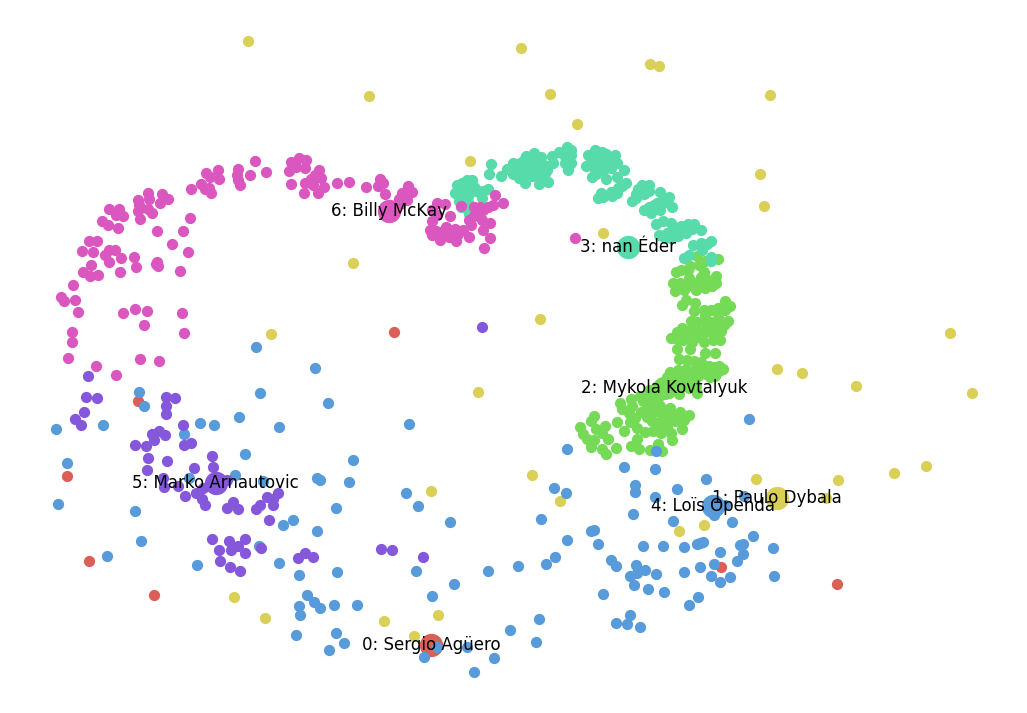

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Display graph
plt.figure(figsize=(13, 9))
node_size = 50
count = 0

# Generate a spring layout for the nodes
pos = nx.spring_layout(G_main_com)

# Use seaborn color palette for community colors
colors = dict(zip(communities.keys(), sns.color_palette('hls', len(communities.keys()))))

# Iterate through each community
for com in communities.keys():
    count = count + 1
    
    # Extract nodes belonging to the current community
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com and nodes not in communities.values()]
    
    # Draw nodes for each community
    nx.draw_networkx_nodes(G_main_com, pos, list_nodes, node_size=node_size, node_color=colors[com])
    
    # Draw a larger node for the community center
    nx.draw_networkx_nodes(G_main_com, pos, list([communities[com]]), node_size=node_size*5, node_color=colors[com])

# Label the community centers
labels = {k: str(v) + ': ' + k for k, v in centers.items()}
nx.draw_networkx_labels(G_main_com, pos, labels)

# Turn off axis labels
plt.axis('off')

# Display the plot
plt.show()


In [72]:
import pandas as pd

# Assign community information to nodes in the graph
for node, community_id in partition.items():
    G.nodes[node]['community'] = community_id

# Define a function to print information about communities in the graph
def print_community(G):
    # Get unique community IDs from node attributes
    communities = set(nx.get_node_attributes(G, 'community').values())

    # Iterate through each community
    for community_id in communities:
        print(f"\nCommunity {community_id}:")

        # Create a list to store player data dictionaries for the community
        community_data = []

        # Iterate through nodes in the graph
        for node, attrs in G.nodes(data=True):
            # Check if the node belongs to the current community
            if attrs['community'] == community_id:
                # Keep only the desired fields in each dictionary
                player_data = {field: attrs.get(field, None) for field in attrs}
                community_data.append(player_data)

        # Create a DataFrame from the list of dictionaries
        df = pd.DataFrame(community_data)

        # Display the DataFrame using Pandas default printing
        if not df.empty:
            display(df)
        else:
            print("No players in this community.")
 
print_community(G)



Community 0:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,league_weight,current_club_domestic_competition_id,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community
0,96341,Romelu,Lukaku,0.909091,250,75,0.893773,0.194444,0.635897,left,0.923077,IT1,0.612245,Centre-Forward,0.512295,0.936275,0.153689,0
1,125781,Antoine,Griezmann,0.909091,213,100,0.913919,0.138889,0.639482,left,1.000000,ES1,0.653061,Centre-Forward,0.426854,0.862745,0.200401,0
2,26399,Sergio,Agüero,0.909091,220,57,0.591575,0.083333,0.635241,right,1.000000,ES1,0.714286,Centre-Forward,0.681115,0.848039,0.176471,0
3,18922,Karim,Benzema,0.909091,249,121,0.838828,0.083333,0.630322,right,1.000000,ES1,0.714286,Centre-Forward,0.543668,0.906863,0.264192,0
4,58864,Pierre-Emerick,Aubameyang,0.909091,277,76,0.877289,0.022222,0.626566,right,0.923077,FR1,0.693878,Centre-Forward,0.578288,0.916667,0.158664,0
5,134425,Raheem,Sterling,0.909091,160,123,0.913919,0.250000,0.623862,right,1.000000,GB1,0.571429,Left Winger,0.320641,0.833333,0.246493,0
6,91845,Heung-min,Son,1.000000,193,95,0.908425,0.277778,0.619059,both,1.000000,GB1,0.632653,Left Winger,0.389113,0.901961,0.191532,0
7,3455,Zlatan,Ibrahimović,0.909091,196,78,0.518315,0.011111,0.616615,right,0.923077,IT1,0.836735,Centre-Forward,0.692580,0.955882,0.275618,0



Community 1:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,league_weight,current_club_domestic_competition_id,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community
0,48280,Edinson,Cavani,0.909091,232,47,0.708791,0.013889,0.601751,right,1.000000,ES1,0.734694,Centre-Forward,0.599483,0.901961,0.121447,1
1,371998,NaN,Vinicius Junior,0.909091,61,52,0.340659,0.833333,0.600199,right,1.000000,ES1,0.448980,Left Winger,0.327957,0.862745,0.279570,1
2,406625,Lautaro,Martínez,0.909091,123,40,0.485348,0.611111,0.599871,right,0.923077,IT1,0.510204,Centre-Forward,0.464151,0.852941,0.150943,1
3,105521,Ciro,Immobile,0.909091,250,66,0.826007,0.055556,0.598981,right,0.923077,IT1,0.673469,Centre-Forward,0.554324,0.906863,0.146341,1
4,401923,Victor,Osimhen,0.909091,94,25,0.349817,0.611111,0.594273,right,0.923077,IT1,0.489796,Centre-Forward,0.492147,0.911765,0.130890,1
5,146854,Wissam,Ben Yedder,1.000000,228,70,0.813187,0.055556,0.589886,both,0.923077,FR1,0.653061,Centre-Forward,0.513514,0.833333,0.157658,1
6,487850,Oladapo,Afolayan,0.909091,1,0,0.001832,0.005556,0.586357,right,1.000000,GB1,0.510204,Left Winger,1.000000,0.882353,0.000000,1
7,581670,Louie,Barry,0.909091,1,0,0.001832,0.005556,0.584886,right,1.000000,GB1,0.408163,Left Winger,1.000000,0.852941,0.000000,1
8,68863,Mauro,Icardi,0.909091,204,55,0.699634,0.111111,0.586759,right,0.769231,TR1,0.612245,Centre-Forward,0.534031,0.887255,0.143979,1
9,136114,Simone,Magnaghi,0.909091,2,0,0.003663,0.001111,0.580168,right,0.923077,IT1,0.591837,Centre-Forward,1.000000,0.921569,0.000000,1



Community 2:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,league_weight,current_club_domestic_competition_id,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community
0,162038,Raúl,de Tomás,0.909091,41,6,0.243590,0.027778,0.401505,right,1.000000,ES1,0.571429,Centre-Forward,0.308271,0.882353,0.045113,2
1,234189,NaN,Mahmoud Trezeguet,0.909091,57,38,0.388278,0.050000,0.401437,right,0.769231,TR1,0.571429,Left Winger,0.268868,0.877451,0.179245,2
2,551695,Lassina,Traoré,0.909091,29,16,0.144689,0.033333,0.401082,right,0.769231,UKR1,0.448980,Centre-Forward,0.367089,0.897059,0.202532,2
3,163053,Mame,Thiam,0.909091,59,23,0.324176,0.015556,0.401015,right,0.769231,TR1,0.612245,Left Winger,0.333333,0.906863,0.129944,2
4,268112,Gyrano,Kerk,0.909091,55,50,0.457875,0.016667,0.400975,right,0.846154,BE1,0.551020,Right Winger,0.220000,0.897059,0.200000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,99499,Rafael,Martins,0.909091,64,11,0.375458,0.001111,0.385961,right,0.769231,PO1,0.693878,Centre-Forward,0.312195,0.867647,0.053659,2
164,15163,Andy,Barrowman,0.909091,1,0,0.003663,0.001667,0.388551,right,0.769231,SC1,0.775510,Centre-Forward,0.500000,0.897059,0.000000,2
165,14945,Andriy,Vorobey,0.909091,1,0,0.003663,0.001667,0.388551,right,0.769231,UKR1,0.897959,Centre-Forward,0.500000,0.872549,0.000000,2
166,532,Claudio,Pizarro,0.909091,53,24,0.342491,0.002222,0.388975,right,0.769231,L1,0.897959,Centre-Forward,0.283422,0.901961,0.128342,2



Community 3:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,league_weight,current_club_domestic_competition_id,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community
0,223725,NaN,Munir El Haddadi,0.909091,67,30,0.532967,0.011111,0.417396,left,1.000000,ES1,0.551020,Right Winger,0.230241,0.867647,0.103093,3
1,432982,Andreas,Skov Olsen,0.909091,52,25,0.311355,0.100000,0.417179,left,0.846154,BE1,0.469388,Right Winger,0.305882,0.916667,0.147059,3
2,68778,NaN,Marlos,0.909091,72,70,0.554945,0.002222,0.417265,left,0.769231,UKR1,0.714286,Right Winger,0.237624,0.852941,0.231023,3
3,96828,Simone,Zaza,0.909091,68,22,0.479853,0.001389,0.416857,left,0.923077,IT1,0.653061,Centre-Forward,0.259542,0.911765,0.083969,3
4,164292,Fran,Sol,0.909091,51,8,0.205128,0.005556,0.416854,right,0.769231,UKR1,0.632653,Centre-Forward,0.455357,0.892157,0.071429,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,382528,Kerem,Aktürkoğlu,0.909091,40,36,0.265568,0.094444,0.401807,right,0.769231,TR1,0.489796,Left Winger,0.275862,0.848039,0.248276,3
134,37934,Hugo,Rodallega,0.909091,75,16,0.434066,0.000833,0.402274,right,0.769231,TR1,0.755102,Centre-Forward,0.316456,0.887255,0.067511,3
135,503212,NaN,Aziz,0.909091,9,3,0.036630,0.011111,0.401521,right,0.769231,PO1,0.489796,Centre-Forward,0.450000,0.916667,0.150000,3
136,45403,André,Ayew,0.909091,56,29,0.443223,0.006667,0.401226,left,0.923077,FR1,0.673469,Left Winger,0.231405,0.857843,0.119835,3



Community 4:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,league_weight,current_club_domestic_competition_id,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community
0,28396,Edin,Dzeko,0.909091,207,100,0.921245,0.020000,0.545180,right,0.769231,TR1,0.755102,Centre-Forward,0.411531,0.946078,0.198807,4
1,192565,Leroy,Sané,0.909091,96,97,0.626374,0.444444,0.541875,left,0.769231,L1,0.551020,Right Winger,0.280702,0.897059,0.283626,4
2,167850,Memphis,Depay,0.909091,147,87,0.719780,0.066667,0.540792,right,1.000000,ES1,0.591837,Centre-Forward,0.374046,0.872549,0.221374,4
3,36139,Dusan,Tadic,0.909091,171,188,0.919414,0.027778,0.540783,left,0.769231,TR1,0.693878,Left Winger,0.340637,0.887255,0.374502,4
4,406635,Phil,Foden,0.909091,66,42,0.421245,0.611111,0.539945,left,1.000000,GB1,0.469388,Right Winger,0.286957,0.838235,0.182609,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,18829,NaN,Vágner Love,1.000000,60,16,0.201465,0.001389,0.473166,both,0.769231,DK1,0.795918,Centre-Forward,0.545455,0.843137,0.145455,4
122,34601,Raúl,García,0.909091,109,48,0.816850,0.011111,0.469327,right,1.000000,ES1,0.755102,Centre-Forward,0.244395,0.901961,0.107623,4
123,44624,Dieumerci,Mbokani,0.909091,98,41,0.410256,0.001111,0.468598,right,0.846154,BE1,0.755102,Centre-Forward,0.437500,0.906863,0.183036,4
124,18644,Álvaro,Negredo,0.909091,107,41,0.633700,0.004444,0.471508,left,1.000000,ES1,0.755102,Centre-Forward,0.309249,0.911765,0.118497,4



Community 5:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,league_weight,current_club_domestic_competition_id,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community
0,339314,Deniz,Undav,0.909091,43,14,0.146520,0.094444,0.466002,right,0.769231,L1,0.530612,Centre-Forward,0.537500,0.877451,0.175000,5
1,426620,Pedro,Gonçalves,0.909091,69,46,0.336996,0.155556,0.464089,right,0.769231,PO1,0.510204,Right Winger,0.375000,0.848039,0.250000,5
2,6031,Antonio,Di Natale,0.909091,68,20,0.254579,0.005556,0.463932,right,0.923077,IT1,0.918367,Centre-Forward,0.489209,0.833333,0.143885,5
3,45146,Mario,Balotelli,0.909091,113,20,0.489011,0.005556,0.463426,right,0.769231,TR1,0.653061,Centre-Forward,0.423221,0.926471,0.074906,5
4,283130,Moussa,Marega,0.909091,89,48,0.406593,0.019444,0.463366,right,0.769231,PO1,0.653061,Right Winger,0.400901,0.897059,0.216216,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,48974,NaN,Luiz Adriano,0.909091,98,45,0.463370,0.002222,0.449911,right,0.769231,TR1,0.734694,Centre-Forward,0.387352,0.901961,0.177866,5
59,242086,Patrik,Schick,0.909091,78,19,0.406593,0.122222,0.448668,left,0.769231,L1,0.551020,Centre-Forward,0.351351,0.936275,0.085586,5
60,22068,Franck,Ribéry,0.909091,61,94,0.562271,0.005556,0.450252,right,0.923077,IT1,0.816327,Left Winger,0.198697,0.833333,0.306189,5
61,20005,NaN,Papu Gómez,0.909091,82,89,0.745421,0.011111,0.449389,right,0.923077,IT1,0.714286,Left Winger,0.201474,0.818627,0.218673,5



Community 6:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,league_weight,current_club_domestic_competition_id,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community
0,739443,Igor,Thiago,0.909091,15,3,0.049451,0.033333,0.447200,right,0.846154,BE1,0.448980,Centre-Forward,0.555556,0.936275,0.111111,6
1,145988,Wilfried,Zaha,0.909091,80,51,0.641026,0.094444,0.446905,right,0.769231,TR1,0.612245,Left Winger,0.228571,0.882353,0.145714,6
2,166240,Jürgen,Locadia,0.909091,74,43,0.443223,0.010000,0.446874,right,1.000000,GB1,0.591837,Centre-Forward,0.305785,0.946078,0.177686,6
3,34944,Konstantinos,Mitroglou,1.000000,92,13,0.390110,0.001111,0.447958,both,0.769231,GR1,0.714286,Centre-Forward,0.431925,0.921569,0.061033,6
4,36371,Nikola,Kalinic,1.000000,87,25,0.521978,0.001667,0.446604,both,0.923077,IT1,0.714286,Centre-Forward,0.305263,0.916667,0.087719,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,327757,Krzysztof,Piatek,0.909091,66,12,0.349817,0.030556,0.418580,right,0.769231,TR1,0.571429,Centre-Forward,0.345550,0.897059,0.062827,6
143,246968,Ayoze,Pérez,0.909091,61,23,0.545788,0.038889,0.418515,right,1.000000,ES1,0.591837,Left Winger,0.204698,0.872549,0.077181,6
144,626913,Boulaye,Dia,0.909091,51,15,0.296703,0.100000,0.418414,right,0.923077,IT1,0.530612,Centre-Forward,0.314815,0.882353,0.092593,6
145,45660,Eric Maxim,Choupo-Moting,0.909091,84,37,0.604396,0.016667,0.417881,right,0.769231,L1,0.693878,Centre-Forward,0.254545,0.936275,0.112121,6


In [73]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering

# Create a copy of the initial graph to retain the original structure
G_spectral = G_beginning.copy()

# Extract network features (centrality measures)
centrality_measures = {
    'degree_centrality': nx.degree_centrality(G_spectral),
    'closeness_centrality': nx.closeness_centrality(G_spectral),
    'betweenness_centrality': nx.betweenness_centrality(G_spectral),
}

# Add network features to each node
for measure_name, values in centrality_measures.items():
    nx.set_node_attributes(G_spectral, values, measure_name)

# Combine network features with 'SKORE' as the feature matrix
feature_matrix = []
for node in G_beginning.nodes:
    # Create a feature vector including centrality measures and 'SKORE'
    feature_vector = [G_spectral.nodes[node][measure] for measure in centrality_measures] + [G_spectral.nodes[node]['SKORE']]
    feature_matrix.append(feature_vector)

# Standardize the feature matrix
scaler = StandardScaler()
feature_matrix_standardized = scaler.fit_transform(feature_matrix)

# Apply Spectral Clustering 
spectral = SpectralClustering( affinity='nearest_neighbors')
cluster_labels = spectral.fit_predict(feature_matrix_standardized)

# Add cluster information to the nodes
for node, cluster_label in zip(G_spectral.nodes, cluster_labels):
    G_spectral.nodes[node]['cluster'] = cluster_label


In [74]:
from networkx.algorithms.community import modularity

# Convert the networkx graph to the format required by the community module
partition = {node: G_spectral.nodes[node]['cluster'] for node in G_spectral.nodes}

# Calculate modularity 
modularity_value = modularity(G_spectral, [set(partition.keys())])

# Print the calculated modularity value
print(f"Modularity: {modularity_value}")


Modularity: 4.6629367034256575e-15


In [75]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(feature_matrix_standardized, cluster_labels)

# Print the calculated silhouette score
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.18980407006879135


In [76]:
# Initialize a dictionary to store nodes belonging to each community
community_sets = {}

# Populate the dictionary with nodes belonging to each community
for node, community_id in partition.items():
    if community_id not in community_sets:
        community_sets[community_id] = set()
    community_sets[community_id].add(node)

# Calculate the union set of all nodes across communities
union_set = set().union(*community_sets.values())

# Calculate coverage as the ratio of the union set size to the total number of nodes in the graph
coverage_value = len(union_set) / len(G_spectral.nodes)

# Print the coverage value
print(f"Coverage: {coverage_value}")

Coverage: 1.0


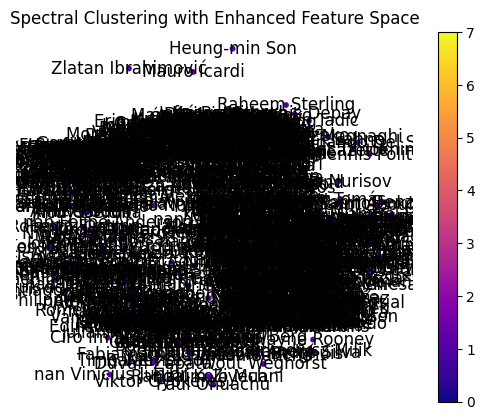

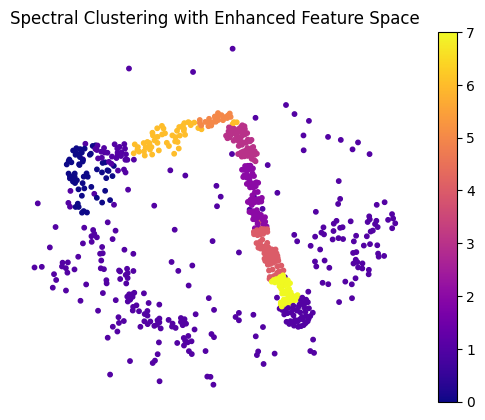

In [77]:
# Generate a spring layout for the nodes
pos = nx.spring_layout(G_spectral)

# Extract cluster labels for each node
node_colors = [G_spectral.nodes[node]['cluster'] for node in G_spectral.nodes]

# Plot the network with labeled nodes and a colorbar
nodes = nx.draw_networkx_nodes(G_spectral, pos, node_size=10, cmap=plt.cm.plasma, node_color=node_colors)
labels = nx.draw_networkx_labels(G_spectral, pos)
plt.title('Spectral Clustering with Enhanced Feature Space')
plt.colorbar(nodes)  # Colorbar represents the clusters
plt.axis('off')
plt.show()

# Plot the network without labeled nodes and a colorbar
nodes = nx.draw_networkx_nodes(G_spectral, pos, node_size=10, cmap=plt.cm.plasma, node_color=node_colors)
plt.title('Spectral Clustering with Enhanced Feature Space')
plt.colorbar(nodes)  # Colorbar represents the clusters
plt.axis('off')
plt.show()


In [78]:
print_community(G_spectral)


Community 0:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,...,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community,degree_centrality,closeness_centrality,betweenness_centrality,cluster
0,96341,Romelu,Lukaku,0.909091,250,75,0.893773,0.194444,0.635897,left,...,0.612245,Centre-Forward,0.512295,0.936275,0.153689,0,0.002911,0.003242,0.000000,1
1,125781,Antoine,Griezmann,0.909091,213,100,0.913919,0.138889,0.639482,left,...,0.653061,Centre-Forward,0.426854,0.862745,0.200401,0,0.002911,0.003242,0.000000,1
2,26399,Sergio,Agüero,0.909091,220,57,0.591575,0.083333,0.635241,right,...,0.714286,Centre-Forward,0.681115,0.848039,0.176471,0,0.004367,0.004196,0.000042,1
3,18922,Karim,Benzema,0.909091,249,121,0.838828,0.083333,0.630322,right,...,0.714286,Centre-Forward,0.543668,0.906863,0.264192,0,0.002911,0.004755,0.000051,1
4,58864,Pierre-Emerick,Aubameyang,0.909091,277,76,0.877289,0.022222,0.626566,right,...,0.693878,Centre-Forward,0.578288,0.916667,0.158664,0,0.002911,0.004755,0.000051,1
5,134425,Raheem,Sterling,0.909091,160,123,0.913919,0.250000,0.623862,right,...,0.571429,Left Winger,0.320641,0.833333,0.246493,0,0.002911,0.004196,0.000042,1
6,91845,Heung-min,Son,1.000000,193,95,0.908425,0.277778,0.619059,both,...,0.632653,Left Winger,0.389113,0.901961,0.191532,0,0.002911,0.003396,0.000025,1
7,3455,Zlatan,Ibrahimović,0.909091,196,78,0.518315,0.011111,0.616615,right,...,0.836735,Centre-Forward,0.692580,0.955882,0.275618,0,0.001456,0.002642,0.000000,1



Community 1:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,...,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community,degree_centrality,closeness_centrality,betweenness_centrality,cluster
0,48280,Edinson,Cavani,0.909091,232,47,0.708791,0.013889,0.601751,right,...,0.734694,Centre-Forward,0.599483,0.901961,0.121447,1,0.004367,0.007380,0.000000,1
1,371998,NaN,Vinicius Junior,0.909091,61,52,0.340659,0.833333,0.600199,right,...,0.448980,Left Winger,0.327957,0.862745,0.279570,1,0.004367,0.007380,0.000000,1
2,406625,Lautaro,Martínez,0.909091,123,40,0.485348,0.611111,0.599871,right,...,0.510204,Centre-Forward,0.464151,0.852941,0.150943,1,0.004367,0.007380,0.000000,1
3,105521,Ciro,Immobile,0.909091,250,66,0.826007,0.055556,0.598981,right,...,0.673469,Centre-Forward,0.554324,0.906863,0.146341,1,0.005822,0.008444,0.000433,1
4,401923,Victor,Osimhen,0.909091,94,25,0.349817,0.611111,0.594273,right,...,0.489796,Centre-Forward,0.492147,0.911765,0.130890,1,0.002911,0.009673,0.000560,1
5,146854,Wissam,Ben Yedder,1.000000,228,70,0.813187,0.055556,0.589886,both,...,0.653061,Centre-Forward,0.513514,0.833333,0.157658,1,0.005822,0.011195,0.000679,1
6,487850,Oladapo,Afolayan,0.909091,1,0,0.001832,0.005556,0.586357,right,...,0.510204,Left Winger,1.000000,0.882353,0.000000,1,0.004367,0.010889,0.000000,1
7,581670,Louie,Barry,0.909091,1,0,0.001832,0.005556,0.584886,right,...,0.408163,Left Winger,1.000000,0.852941,0.000000,1,0.007278,0.012940,0.000985,1
8,68863,Mauro,Icardi,0.909091,204,55,0.699634,0.111111,0.586759,right,...,0.612245,Centre-Forward,0.534031,0.887255,0.143979,1,0.004367,0.010889,0.000000,1
9,136114,Simone,Magnaghi,0.909091,2,0,0.003663,0.001111,0.580168,right,...,0.591837,Centre-Forward,1.000000,0.921569,0.000000,1,0.013100,0.014761,0.000516,1



Community 2:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,...,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community,degree_centrality,closeness_centrality,betweenness_centrality,cluster
0,162038,Raúl,de Tomás,0.909091,41,6,0.243590,0.027778,0.401505,right,...,0.571429,Centre-Forward,0.308271,0.882353,0.045113,2,0.126638,0.228014,0.001323,2
1,234189,NaN,Mahmoud Trezeguet,0.909091,57,38,0.388278,0.050000,0.401437,right,...,0.571429,Left Winger,0.268868,0.877451,0.179245,2,0.128093,0.228362,0.001465,2
2,551695,Lassina,Traoré,0.909091,29,16,0.144689,0.033333,0.401082,right,...,0.448980,Centre-Forward,0.367089,0.897059,0.202532,2,0.133916,0.229325,0.002253,2
3,163053,Mame,Thiam,0.909091,59,23,0.324176,0.015556,0.401015,right,...,0.612245,Left Winger,0.333333,0.906863,0.129944,2,0.138282,0.229677,0.002820,4
4,268112,Gyrano,Kerk,0.909091,55,50,0.457875,0.016667,0.400975,right,...,0.551020,Right Winger,0.220000,0.897059,0.200000,2,0.136827,0.229589,0.002764,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,99499,Rafael,Martins,0.909091,64,11,0.375458,0.001111,0.385961,right,...,0.693878,Centre-Forward,0.312195,0.867647,0.053659,2,0.087336,0.152571,0.000000,1
164,15163,Andy,Barrowman,0.909091,1,0,0.003663,0.001667,0.388551,right,...,0.775510,Centre-Forward,0.500000,0.897059,0.000000,2,0.128093,0.160558,0.000169,1
165,14945,Andriy,Vorobey,0.909091,1,0,0.003663,0.001667,0.388551,right,...,0.897959,Centre-Forward,0.500000,0.872549,0.000000,2,0.128093,0.160558,0.000169,1
166,532,Claudio,Pizarro,0.909091,53,24,0.342491,0.002222,0.388975,right,...,0.897959,Centre-Forward,0.283422,0.901961,0.128342,2,0.135371,0.170978,0.000379,7



Community 3:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,...,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community,degree_centrality,closeness_centrality,betweenness_centrality,cluster
0,223725,NaN,Munir El Haddadi,0.909091,67,30,0.532967,0.011111,0.417396,left,...,0.551020,Right Winger,0.230241,0.867647,0.103093,3,0.097525,0.178798,0.000846,5
1,432982,Andreas,Skov Olsen,0.909091,52,25,0.311355,0.100000,0.417179,left,...,0.469388,Right Winger,0.305882,0.916667,0.147059,3,0.098981,0.178852,0.000819,5
2,68778,NaN,Marlos,0.909091,72,70,0.554945,0.002222,0.417265,left,...,0.714286,Right Winger,0.237624,0.852941,0.231023,3,0.098981,0.178852,0.000871,5
3,96828,Simone,Zaza,0.909091,68,22,0.479853,0.001389,0.416857,left,...,0.653061,Centre-Forward,0.259542,0.911765,0.083969,3,0.098981,0.178106,0.000547,5
4,164292,Fran,Sol,0.909091,51,8,0.205128,0.005556,0.416854,right,...,0.632653,Centre-Forward,0.455357,0.892157,0.071429,3,0.098981,0.178106,0.000547,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,382528,Kerem,Aktürkoğlu,0.909091,40,36,0.265568,0.094444,0.401807,right,...,0.489796,Left Winger,0.275862,0.848039,0.248276,3,0.129549,0.227234,0.001220,2
134,37934,Hugo,Rodallega,0.909091,75,16,0.434066,0.000833,0.402274,right,...,0.755102,Centre-Forward,0.316456,0.887255,0.067511,3,0.125182,0.226203,0.000601,2
135,503212,NaN,Aziz,0.909091,9,3,0.036630,0.011111,0.401521,right,...,0.489796,Centre-Forward,0.450000,0.916667,0.150000,3,0.128093,0.228101,0.001363,2
136,45403,André,Ayew,0.909091,56,29,0.443223,0.006667,0.401226,left,...,0.673469,Left Winger,0.231405,0.857843,0.119835,3,0.129549,0.228624,0.001620,2



Community 4:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,...,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community,degree_centrality,closeness_centrality,betweenness_centrality,cluster
0,28396,Edin,Dzeko,0.909091,207,100,0.921245,0.020000,0.545180,right,...,0.755102,Centre-Forward,0.411531,0.946078,0.198807,4,0.004367,0.044813,0.000000,1
1,192565,Leroy,Sané,0.909091,96,97,0.626374,0.444444,0.541875,left,...,0.551020,Right Winger,0.280702,0.897059,0.283626,4,0.008734,0.047063,0.000903,1
2,167850,Memphis,Depay,0.909091,147,87,0.719780,0.066667,0.540792,right,...,0.591837,Centre-Forward,0.374046,0.872549,0.221374,4,0.008734,0.047063,0.000903,1
3,36139,Dusan,Tadic,0.909091,171,188,0.919414,0.027778,0.540783,left,...,0.693878,Left Winger,0.340637,0.887255,0.374502,4,0.008734,0.047063,0.000903,1
4,406635,Phil,Foden,0.909091,66,42,0.421245,0.611111,0.539945,left,...,0.469388,Right Winger,0.286957,0.838235,0.182609,4,0.010189,0.047123,0.000049,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,18829,NaN,Vágner Love,1.000000,60,16,0.201465,0.001389,0.473166,both,...,0.795918,Centre-Forward,0.545455,0.843137,0.145455,4,0.039301,0.151758,0.016975,1
122,34601,Raúl,García,0.909091,109,48,0.816850,0.011111,0.469327,right,...,0.755102,Centre-Forward,0.244395,0.901961,0.107623,4,0.033479,0.151298,0.002226,1
123,44624,Dieumerci,Mbokani,0.909091,98,41,0.410256,0.001111,0.468598,right,...,0.755102,Centre-Forward,0.437500,0.906863,0.183036,4,0.034934,0.169572,0.043826,1
124,18644,Álvaro,Negredo,0.909091,107,41,0.633700,0.004444,0.471508,left,...,0.755102,Centre-Forward,0.309249,0.911765,0.118497,4,0.034934,0.149820,0.001215,1



Community 5:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,...,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community,degree_centrality,closeness_centrality,betweenness_centrality,cluster
0,339314,Deniz,Undav,0.909091,43,14,0.146520,0.094444,0.466002,right,...,0.530612,Centre-Forward,0.537500,0.877451,0.175000,5,0.036390,0.168284,0.019083,1
1,426620,Pedro,Gonçalves,0.909091,69,46,0.336996,0.155556,0.464089,right,...,0.510204,Right Winger,0.375000,0.848039,0.250000,5,0.040757,0.190775,0.104562,1
2,6031,Antonio,Di Natale,0.909091,68,20,0.254579,0.005556,0.463932,right,...,0.918367,Centre-Forward,0.489209,0.833333,0.143885,5,0.039301,0.190714,0.080969,1
3,45146,Mario,Balotelli,0.909091,113,20,0.489011,0.005556,0.463426,right,...,0.653061,Centre-Forward,0.423221,0.926471,0.074906,5,0.039301,0.190958,0.023336,1
4,283130,Moussa,Marega,0.909091,89,48,0.406593,0.019444,0.463366,right,...,0.653061,Right Winger,0.400901,0.897059,0.216216,5,0.039301,0.190958,0.023336,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,48974,NaN,Luiz Adriano,0.909091,98,45,0.463370,0.002222,0.449911,right,...,0.734694,Centre-Forward,0.387352,0.901961,0.177866,5,0.042213,0.180634,0.005589,1
59,242086,Patrik,Schick,0.909091,78,19,0.406593,0.122222,0.448668,left,...,0.551020,Centre-Forward,0.351351,0.936275,0.085586,5,0.045124,0.175287,0.005762,1
60,22068,Franck,Ribéry,0.909091,61,94,0.562271,0.005556,0.450252,right,...,0.816327,Left Winger,0.198697,0.833333,0.306189,5,0.040757,0.179604,0.001079,1
61,20005,NaN,Papu Gómez,0.909091,82,89,0.745421,0.011111,0.449389,right,...,0.714286,Left Winger,0.201474,0.818627,0.218673,5,0.042213,0.180036,0.005123,1



Community 6:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,...,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community,degree_centrality,closeness_centrality,betweenness_centrality,cluster
0,739443,Igor,Thiago,0.909091,15,3,0.049451,0.033333,0.447200,right,...,0.448980,Centre-Forward,0.555556,0.936275,0.111111,6,0.039301,0.174980,0.002454,1
1,145988,Wilfried,Zaha,0.909091,80,51,0.641026,0.094444,0.446905,right,...,0.612245,Left Winger,0.228571,0.882353,0.145714,6,0.043668,0.175906,0.006288,1
2,166240,Jürgen,Locadia,0.909091,74,43,0.443223,0.010000,0.446874,right,...,0.591837,Centre-Forward,0.305785,0.946078,0.177686,6,0.043668,0.175906,0.006288,1
3,34944,Konstantinos,Mitroglou,1.000000,92,13,0.390110,0.001111,0.447958,both,...,0.714286,Centre-Forward,0.431925,0.921569,0.061033,6,0.046579,0.175854,0.009446,1
4,36371,Nikola,Kalinic,1.000000,87,25,0.521978,0.001667,0.446604,both,...,0.714286,Centre-Forward,0.305263,0.916667,0.087719,6,0.045124,0.174826,0.007365,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,327757,Krzysztof,Piatek,0.909091,66,12,0.349817,0.030556,0.418580,right,...,0.571429,Centre-Forward,0.345550,0.897059,0.062827,6,0.091703,0.179173,0.001058,5
143,246968,Ayoze,Pérez,0.909091,61,23,0.545788,0.038889,0.418515,right,...,0.591837,Left Winger,0.204698,0.872549,0.077181,6,0.090247,0.179120,0.000902,5
144,626913,Boulaye,Dia,0.909091,51,15,0.296703,0.100000,0.418414,right,...,0.530612,Centre-Forward,0.314815,0.882353,0.092593,6,0.090247,0.179120,0.000902,5
145,45660,Eric Maxim,Choupo-Moting,0.909091,84,37,0.604396,0.016667,0.417881,right,...,0.693878,Centre-Forward,0.254545,0.936275,0.112121,6,0.088792,0.178691,0.000608,5


In [79]:
from networkx.algorithms.community import greedy_modularity_communities
G_spinglass = G_beginning;
communities = list(nx.community.greedy_modularity_communities(G_spinglass))



In [80]:
from networkx.algorithms.community import greedy_modularity_communities, modularity

# Apply Spinglass Algorithm
communities = list(greedy_modularity_communities(G_spinglass))

# Convert the community structure to a partition dictionary
partition = {node: idx for idx, community in enumerate(communities) for node in community}

# Calculate modularity
modularity_value = modularity(G_spinglass, [set(community) for community in communities])

print(f"Modularity: {modularity_value}")


Modularity: 0.4385619481418118


In [81]:

# Calculate coverage
community_sets = {}
for node, community_id in partition.items():
    if community_id not in community_sets:
        community_sets[community_id] = set()
    community_sets[community_id].add(node)

union_set = set().union(*community_sets.values())
coverage_value = len(union_set) / len(G_spinglass.nodes)
print(f"Coverage: {coverage_value}")

Coverage: 1.0


In [82]:
feature_matrix = []
for node in G_spinglass.nodes:
    feature_vector =   [G_spinglass.nodes[node]['SKORE']]
    feature_matrix.append(feature_vector)

# Standardize the feature matrix
scaler = StandardScaler()
feature_matrix_standardized = scaler.fit_transform(feature_matrix) 
cluster_labels = list(partition.values())

# Calculate silhouette score
silhouette_avg = silhouette_score(feature_matrix_standardized, cluster_labels)

print(f"Silhouette Score: {silhouette_avg}")

 

Silhouette Score: 0.10318635288566981


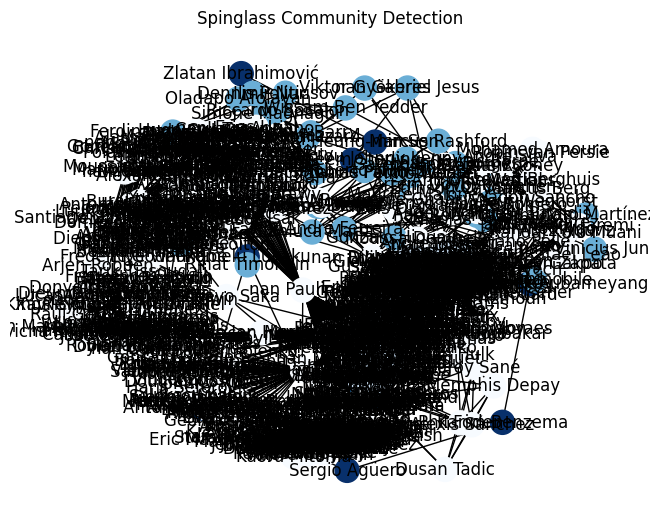

In [83]:
community_graph = nx.Graph()

# Add nodes and edges based on detected communities
for i, community_nodes in enumerate(communities):
    community_graph.add_nodes_from(community_nodes, community=i)
    community_graph.add_edges_from(nx.complete_graph(community_nodes).edges())

# Draw the graph with different colors for each community
pos = nx.spring_layout(G_spinglass)
community_colors = [community_graph.nodes[node]['community'] for node in G_spinglass.nodes]

nx.draw(G_spinglass, pos, node_color=community_colors, with_labels=True, cmap=plt.cm.Blues)
plt.title("Spinglass Community Detection")
plt.show()

In [84]:
print_community(G_spinglass)


Community 0:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,league_weight,current_club_domestic_competition_id,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community
0,96341,Romelu,Lukaku,0.909091,250,75,0.893773,0.194444,0.635897,left,0.923077,IT1,0.612245,Centre-Forward,0.512295,0.936275,0.153689,0
1,125781,Antoine,Griezmann,0.909091,213,100,0.913919,0.138889,0.639482,left,1.000000,ES1,0.653061,Centre-Forward,0.426854,0.862745,0.200401,0
2,26399,Sergio,Agüero,0.909091,220,57,0.591575,0.083333,0.635241,right,1.000000,ES1,0.714286,Centre-Forward,0.681115,0.848039,0.176471,0
3,18922,Karim,Benzema,0.909091,249,121,0.838828,0.083333,0.630322,right,1.000000,ES1,0.714286,Centre-Forward,0.543668,0.906863,0.264192,0
4,58864,Pierre-Emerick,Aubameyang,0.909091,277,76,0.877289,0.022222,0.626566,right,0.923077,FR1,0.693878,Centre-Forward,0.578288,0.916667,0.158664,0
5,134425,Raheem,Sterling,0.909091,160,123,0.913919,0.250000,0.623862,right,1.000000,GB1,0.571429,Left Winger,0.320641,0.833333,0.246493,0
6,91845,Heung-min,Son,1.000000,193,95,0.908425,0.277778,0.619059,both,1.000000,GB1,0.632653,Left Winger,0.389113,0.901961,0.191532,0
7,3455,Zlatan,Ibrahimović,0.909091,196,78,0.518315,0.011111,0.616615,right,0.923077,IT1,0.836735,Centre-Forward,0.692580,0.955882,0.275618,0



Community 1:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,league_weight,current_club_domestic_competition_id,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community
0,48280,Edinson,Cavani,0.909091,232,47,0.708791,0.013889,0.601751,right,1.000000,ES1,0.734694,Centre-Forward,0.599483,0.901961,0.121447,1
1,371998,NaN,Vinicius Junior,0.909091,61,52,0.340659,0.833333,0.600199,right,1.000000,ES1,0.448980,Left Winger,0.327957,0.862745,0.279570,1
2,406625,Lautaro,Martínez,0.909091,123,40,0.485348,0.611111,0.599871,right,0.923077,IT1,0.510204,Centre-Forward,0.464151,0.852941,0.150943,1
3,105521,Ciro,Immobile,0.909091,250,66,0.826007,0.055556,0.598981,right,0.923077,IT1,0.673469,Centre-Forward,0.554324,0.906863,0.146341,1
4,401923,Victor,Osimhen,0.909091,94,25,0.349817,0.611111,0.594273,right,0.923077,IT1,0.489796,Centre-Forward,0.492147,0.911765,0.130890,1
5,146854,Wissam,Ben Yedder,1.000000,228,70,0.813187,0.055556,0.589886,both,0.923077,FR1,0.653061,Centre-Forward,0.513514,0.833333,0.157658,1
6,487850,Oladapo,Afolayan,0.909091,1,0,0.001832,0.005556,0.586357,right,1.000000,GB1,0.510204,Left Winger,1.000000,0.882353,0.000000,1
7,581670,Louie,Barry,0.909091,1,0,0.001832,0.005556,0.584886,right,1.000000,GB1,0.408163,Left Winger,1.000000,0.852941,0.000000,1
8,68863,Mauro,Icardi,0.909091,204,55,0.699634,0.111111,0.586759,right,0.769231,TR1,0.612245,Centre-Forward,0.534031,0.887255,0.143979,1
9,136114,Simone,Magnaghi,0.909091,2,0,0.003663,0.001111,0.580168,right,0.923077,IT1,0.591837,Centre-Forward,1.000000,0.921569,0.000000,1



Community 2:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,league_weight,current_club_domestic_competition_id,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community
0,162038,Raúl,de Tomás,0.909091,41,6,0.243590,0.027778,0.401505,right,1.000000,ES1,0.571429,Centre-Forward,0.308271,0.882353,0.045113,2
1,234189,NaN,Mahmoud Trezeguet,0.909091,57,38,0.388278,0.050000,0.401437,right,0.769231,TR1,0.571429,Left Winger,0.268868,0.877451,0.179245,2
2,551695,Lassina,Traoré,0.909091,29,16,0.144689,0.033333,0.401082,right,0.769231,UKR1,0.448980,Centre-Forward,0.367089,0.897059,0.202532,2
3,163053,Mame,Thiam,0.909091,59,23,0.324176,0.015556,0.401015,right,0.769231,TR1,0.612245,Left Winger,0.333333,0.906863,0.129944,2
4,268112,Gyrano,Kerk,0.909091,55,50,0.457875,0.016667,0.400975,right,0.846154,BE1,0.551020,Right Winger,0.220000,0.897059,0.200000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,99499,Rafael,Martins,0.909091,64,11,0.375458,0.001111,0.385961,right,0.769231,PO1,0.693878,Centre-Forward,0.312195,0.867647,0.053659,2
164,15163,Andy,Barrowman,0.909091,1,0,0.003663,0.001667,0.388551,right,0.769231,SC1,0.775510,Centre-Forward,0.500000,0.897059,0.000000,2
165,14945,Andriy,Vorobey,0.909091,1,0,0.003663,0.001667,0.388551,right,0.769231,UKR1,0.897959,Centre-Forward,0.500000,0.872549,0.000000,2
166,532,Claudio,Pizarro,0.909091,53,24,0.342491,0.002222,0.388975,right,0.769231,L1,0.897959,Centre-Forward,0.283422,0.901961,0.128342,2



Community 3:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,league_weight,current_club_domestic_competition_id,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community
0,223725,NaN,Munir El Haddadi,0.909091,67,30,0.532967,0.011111,0.417396,left,1.000000,ES1,0.551020,Right Winger,0.230241,0.867647,0.103093,3
1,432982,Andreas,Skov Olsen,0.909091,52,25,0.311355,0.100000,0.417179,left,0.846154,BE1,0.469388,Right Winger,0.305882,0.916667,0.147059,3
2,68778,NaN,Marlos,0.909091,72,70,0.554945,0.002222,0.417265,left,0.769231,UKR1,0.714286,Right Winger,0.237624,0.852941,0.231023,3
3,96828,Simone,Zaza,0.909091,68,22,0.479853,0.001389,0.416857,left,0.923077,IT1,0.653061,Centre-Forward,0.259542,0.911765,0.083969,3
4,164292,Fran,Sol,0.909091,51,8,0.205128,0.005556,0.416854,right,0.769231,UKR1,0.632653,Centre-Forward,0.455357,0.892157,0.071429,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,382528,Kerem,Aktürkoğlu,0.909091,40,36,0.265568,0.094444,0.401807,right,0.769231,TR1,0.489796,Left Winger,0.275862,0.848039,0.248276,3
134,37934,Hugo,Rodallega,0.909091,75,16,0.434066,0.000833,0.402274,right,0.769231,TR1,0.755102,Centre-Forward,0.316456,0.887255,0.067511,3
135,503212,NaN,Aziz,0.909091,9,3,0.036630,0.011111,0.401521,right,0.769231,PO1,0.489796,Centre-Forward,0.450000,0.916667,0.150000,3
136,45403,André,Ayew,0.909091,56,29,0.443223,0.006667,0.401226,left,0.923077,FR1,0.673469,Left Winger,0.231405,0.857843,0.119835,3



Community 4:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,league_weight,current_club_domestic_competition_id,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community
0,28396,Edin,Dzeko,0.909091,207,100,0.921245,0.020000,0.545180,right,0.769231,TR1,0.755102,Centre-Forward,0.411531,0.946078,0.198807,4
1,192565,Leroy,Sané,0.909091,96,97,0.626374,0.444444,0.541875,left,0.769231,L1,0.551020,Right Winger,0.280702,0.897059,0.283626,4
2,167850,Memphis,Depay,0.909091,147,87,0.719780,0.066667,0.540792,right,1.000000,ES1,0.591837,Centre-Forward,0.374046,0.872549,0.221374,4
3,36139,Dusan,Tadic,0.909091,171,188,0.919414,0.027778,0.540783,left,0.769231,TR1,0.693878,Left Winger,0.340637,0.887255,0.374502,4
4,406635,Phil,Foden,0.909091,66,42,0.421245,0.611111,0.539945,left,1.000000,GB1,0.469388,Right Winger,0.286957,0.838235,0.182609,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,18829,NaN,Vágner Love,1.000000,60,16,0.201465,0.001389,0.473166,both,0.769231,DK1,0.795918,Centre-Forward,0.545455,0.843137,0.145455,4
122,34601,Raúl,García,0.909091,109,48,0.816850,0.011111,0.469327,right,1.000000,ES1,0.755102,Centre-Forward,0.244395,0.901961,0.107623,4
123,44624,Dieumerci,Mbokani,0.909091,98,41,0.410256,0.001111,0.468598,right,0.846154,BE1,0.755102,Centre-Forward,0.437500,0.906863,0.183036,4
124,18644,Álvaro,Negredo,0.909091,107,41,0.633700,0.004444,0.471508,left,1.000000,ES1,0.755102,Centre-Forward,0.309249,0.911765,0.118497,4



Community 5:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,league_weight,current_club_domestic_competition_id,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community
0,339314,Deniz,Undav,0.909091,43,14,0.146520,0.094444,0.466002,right,0.769231,L1,0.530612,Centre-Forward,0.537500,0.877451,0.175000,5
1,426620,Pedro,Gonçalves,0.909091,69,46,0.336996,0.155556,0.464089,right,0.769231,PO1,0.510204,Right Winger,0.375000,0.848039,0.250000,5
2,6031,Antonio,Di Natale,0.909091,68,20,0.254579,0.005556,0.463932,right,0.923077,IT1,0.918367,Centre-Forward,0.489209,0.833333,0.143885,5
3,45146,Mario,Balotelli,0.909091,113,20,0.489011,0.005556,0.463426,right,0.769231,TR1,0.653061,Centre-Forward,0.423221,0.926471,0.074906,5
4,283130,Moussa,Marega,0.909091,89,48,0.406593,0.019444,0.463366,right,0.769231,PO1,0.653061,Right Winger,0.400901,0.897059,0.216216,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,48974,NaN,Luiz Adriano,0.909091,98,45,0.463370,0.002222,0.449911,right,0.769231,TR1,0.734694,Centre-Forward,0.387352,0.901961,0.177866,5
59,242086,Patrik,Schick,0.909091,78,19,0.406593,0.122222,0.448668,left,0.769231,L1,0.551020,Centre-Forward,0.351351,0.936275,0.085586,5
60,22068,Franck,Ribéry,0.909091,61,94,0.562271,0.005556,0.450252,right,0.923077,IT1,0.816327,Left Winger,0.198697,0.833333,0.306189,5
61,20005,NaN,Papu Gómez,0.909091,82,89,0.745421,0.011111,0.449389,right,0.923077,IT1,0.714286,Left Winger,0.201474,0.818627,0.218673,5



Community 6:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,league_weight,current_club_domestic_competition_id,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community
0,739443,Igor,Thiago,0.909091,15,3,0.049451,0.033333,0.447200,right,0.846154,BE1,0.448980,Centre-Forward,0.555556,0.936275,0.111111,6
1,145988,Wilfried,Zaha,0.909091,80,51,0.641026,0.094444,0.446905,right,0.769231,TR1,0.612245,Left Winger,0.228571,0.882353,0.145714,6
2,166240,Jürgen,Locadia,0.909091,74,43,0.443223,0.010000,0.446874,right,1.000000,GB1,0.591837,Centre-Forward,0.305785,0.946078,0.177686,6
3,34944,Konstantinos,Mitroglou,1.000000,92,13,0.390110,0.001111,0.447958,both,0.769231,GR1,0.714286,Centre-Forward,0.431925,0.921569,0.061033,6
4,36371,Nikola,Kalinic,1.000000,87,25,0.521978,0.001667,0.446604,both,0.923077,IT1,0.714286,Centre-Forward,0.305263,0.916667,0.087719,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,327757,Krzysztof,Piatek,0.909091,66,12,0.349817,0.030556,0.418580,right,0.769231,TR1,0.571429,Centre-Forward,0.345550,0.897059,0.062827,6
143,246968,Ayoze,Pérez,0.909091,61,23,0.545788,0.038889,0.418515,right,1.000000,ES1,0.591837,Left Winger,0.204698,0.872549,0.077181,6
144,626913,Boulaye,Dia,0.909091,51,15,0.296703,0.100000,0.418414,right,0.923077,IT1,0.530612,Centre-Forward,0.314815,0.882353,0.092593,6
145,45660,Eric Maxim,Choupo-Moting,0.909091,84,37,0.604396,0.016667,0.417881,right,0.769231,L1,0.693878,Centre-Forward,0.254545,0.936275,0.112121,6


In [90]:
from networkx.algorithms.community import asyn_fluidc, modularity
G_Walktrap = G_beginning;

if not nx.is_connected(G_Walktrap):
    # Get the largest connected component
    largest_component = max(nx.connected_components(G_Walktrap), key=len)
    
    # Create a subgraph with the largest connected component
    G_Walktrap = G_Walktrap.subgraph(largest_component)

# Apply Walktrap Algorithm
communities = list(asyn_fluidc(G_Walktrap, k=10, seed=42))

# Convert the community structure to a partition dictionary
partition = {node: idx for idx, community in enumerate(communities) for node in community}

# Calculate modularity
modularity_value = modularity(G_Walktrap, [set(community) for community in communities])

print(f"Modularity: {modularity_value}")


Modularity: 0.5817354151794251


In [91]:

# Calculate coverage
community_sets = {}
for node, community_id in partition.items():
    if community_id not in community_sets:
        community_sets[community_id] = set()
    community_sets[community_id].add(node)

union_set = set().union(*community_sets.values())
coverage_value = len(union_set) / len(G_Walktrap.nodes)
print(f"Coverage: {coverage_value}")

Coverage: 1.0


In [92]:
feature_matrix = []
for node in G_Walktrap.nodes:
    feature_vector =   [G_Walktrap.nodes[node]['SKORE']]
    feature_matrix.append(feature_vector)

# Standardize the feature matrix
scaler = StandardScaler()
feature_matrix_standardized = scaler.fit_transform(feature_matrix)
 
cluster_labels = list(partition.values())

# Calculate silhouette score
silhouette_avg = silhouette_score(feature_matrix_standardized, cluster_labels)

print(f"Silhouette Score: {silhouette_avg}")

 

Silhouette Score: 0.3938286227933458


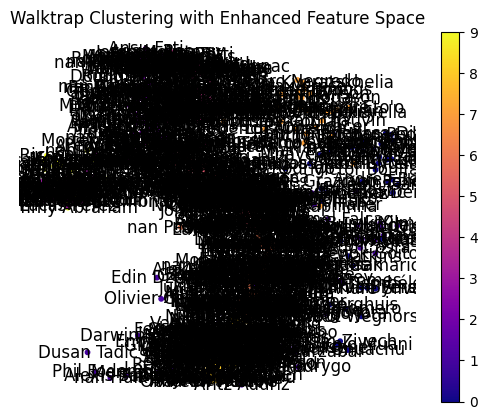

In [95]:
# Assign cluster information to nodes
for idx, community in enumerate(communities):
    for node in community:
        G_Walktrap.nodes[node]['cluster'] = idx


# Visualize the clusters
pos = nx.spring_layout(G_Walktrap)
# Filter nodes for coloring that are present in the layout
valid_nodes = [node for node in G_Walktrap.nodes if node in pos]
node_colors = [G_Walktrap.nodes[node]['cluster'] for node in valid_nodes]
nodes = nx.draw_networkx_nodes(G_Walktrap, pos, nodelist=valid_nodes, node_size=10, cmap=plt.cm.plasma, node_color=node_colors)
labels = nx.draw_networkx_labels(G_Walktrap, pos)
plt.title('Walktrap Clustering with Enhanced Feature Space')
plt.colorbar(nodes)
plt.axis('off')
plt.show()

In [96]:
print_community(G_spinglass)


Community 0:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,league_weight,current_club_domestic_competition_id,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community
0,96341,Romelu,Lukaku,0.909091,250,75,0.893773,0.194444,0.635897,left,0.923077,IT1,0.612245,Centre-Forward,0.512295,0.936275,0.153689,0
1,125781,Antoine,Griezmann,0.909091,213,100,0.913919,0.138889,0.639482,left,1.000000,ES1,0.653061,Centre-Forward,0.426854,0.862745,0.200401,0
2,26399,Sergio,Agüero,0.909091,220,57,0.591575,0.083333,0.635241,right,1.000000,ES1,0.714286,Centre-Forward,0.681115,0.848039,0.176471,0
3,18922,Karim,Benzema,0.909091,249,121,0.838828,0.083333,0.630322,right,1.000000,ES1,0.714286,Centre-Forward,0.543668,0.906863,0.264192,0
4,58864,Pierre-Emerick,Aubameyang,0.909091,277,76,0.877289,0.022222,0.626566,right,0.923077,FR1,0.693878,Centre-Forward,0.578288,0.916667,0.158664,0
5,134425,Raheem,Sterling,0.909091,160,123,0.913919,0.250000,0.623862,right,1.000000,GB1,0.571429,Left Winger,0.320641,0.833333,0.246493,0
6,91845,Heung-min,Son,1.000000,193,95,0.908425,0.277778,0.619059,both,1.000000,GB1,0.632653,Left Winger,0.389113,0.901961,0.191532,0
7,3455,Zlatan,Ibrahimović,0.909091,196,78,0.518315,0.011111,0.616615,right,0.923077,IT1,0.836735,Centre-Forward,0.692580,0.955882,0.275618,0



Community 1:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,league_weight,current_club_domestic_competition_id,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community
0,48280,Edinson,Cavani,0.909091,232,47,0.708791,0.013889,0.601751,right,1.000000,ES1,0.734694,Centre-Forward,0.599483,0.901961,0.121447,1
1,371998,NaN,Vinicius Junior,0.909091,61,52,0.340659,0.833333,0.600199,right,1.000000,ES1,0.448980,Left Winger,0.327957,0.862745,0.279570,1
2,406625,Lautaro,Martínez,0.909091,123,40,0.485348,0.611111,0.599871,right,0.923077,IT1,0.510204,Centre-Forward,0.464151,0.852941,0.150943,1
3,105521,Ciro,Immobile,0.909091,250,66,0.826007,0.055556,0.598981,right,0.923077,IT1,0.673469,Centre-Forward,0.554324,0.906863,0.146341,1
4,401923,Victor,Osimhen,0.909091,94,25,0.349817,0.611111,0.594273,right,0.923077,IT1,0.489796,Centre-Forward,0.492147,0.911765,0.130890,1
5,146854,Wissam,Ben Yedder,1.000000,228,70,0.813187,0.055556,0.589886,both,0.923077,FR1,0.653061,Centre-Forward,0.513514,0.833333,0.157658,1
6,487850,Oladapo,Afolayan,0.909091,1,0,0.001832,0.005556,0.586357,right,1.000000,GB1,0.510204,Left Winger,1.000000,0.882353,0.000000,1
7,581670,Louie,Barry,0.909091,1,0,0.001832,0.005556,0.584886,right,1.000000,GB1,0.408163,Left Winger,1.000000,0.852941,0.000000,1
8,68863,Mauro,Icardi,0.909091,204,55,0.699634,0.111111,0.586759,right,0.769231,TR1,0.612245,Centre-Forward,0.534031,0.887255,0.143979,1
9,136114,Simone,Magnaghi,0.909091,2,0,0.003663,0.001111,0.580168,right,0.923077,IT1,0.591837,Centre-Forward,1.000000,0.921569,0.000000,1



Community 2:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,league_weight,current_club_domestic_competition_id,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community,cluster
0,162038,Raúl,de Tomás,0.909091,41,6,0.243590,0.027778,0.401505,right,1.000000,ES1,0.571429,Centre-Forward,0.308271,0.882353,0.045113,2,6
1,234189,NaN,Mahmoud Trezeguet,0.909091,57,38,0.388278,0.050000,0.401437,right,0.769231,TR1,0.571429,Left Winger,0.268868,0.877451,0.179245,2,6
2,551695,Lassina,Traoré,0.909091,29,16,0.144689,0.033333,0.401082,right,0.769231,UKR1,0.448980,Centre-Forward,0.367089,0.897059,0.202532,2,6
3,163053,Mame,Thiam,0.909091,59,23,0.324176,0.015556,0.401015,right,0.769231,TR1,0.612245,Left Winger,0.333333,0.906863,0.129944,2,6
4,268112,Gyrano,Kerk,0.909091,55,50,0.457875,0.016667,0.400975,right,0.846154,BE1,0.551020,Right Winger,0.220000,0.897059,0.200000,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,99499,Rafael,Martins,0.909091,64,11,0.375458,0.001111,0.385961,right,0.769231,PO1,0.693878,Centre-Forward,0.312195,0.867647,0.053659,2,8
164,15163,Andy,Barrowman,0.909091,1,0,0.003663,0.001667,0.388551,right,0.769231,SC1,0.775510,Centre-Forward,0.500000,0.897059,0.000000,2,8
165,14945,Andriy,Vorobey,0.909091,1,0,0.003663,0.001667,0.388551,right,0.769231,UKR1,0.897959,Centre-Forward,0.500000,0.872549,0.000000,2,8
166,532,Claudio,Pizarro,0.909091,53,24,0.342491,0.002222,0.388975,right,0.769231,L1,0.897959,Centre-Forward,0.283422,0.901961,0.128342,2,8



Community 3:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,league_weight,current_club_domestic_competition_id,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community,cluster
0,223725,NaN,Munir El Haddadi,0.909091,67,30,0.532967,0.011111,0.417396,left,1.000000,ES1,0.551020,Right Winger,0.230241,0.867647,0.103093,3,5
1,432982,Andreas,Skov Olsen,0.909091,52,25,0.311355,0.100000,0.417179,left,0.846154,BE1,0.469388,Right Winger,0.305882,0.916667,0.147059,3,5
2,68778,NaN,Marlos,0.909091,72,70,0.554945,0.002222,0.417265,left,0.769231,UKR1,0.714286,Right Winger,0.237624,0.852941,0.231023,3,5
3,96828,Simone,Zaza,0.909091,68,22,0.479853,0.001389,0.416857,left,0.923077,IT1,0.653061,Centre-Forward,0.259542,0.911765,0.083969,3,5
4,164292,Fran,Sol,0.909091,51,8,0.205128,0.005556,0.416854,right,0.769231,UKR1,0.632653,Centre-Forward,0.455357,0.892157,0.071429,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,382528,Kerem,Aktürkoğlu,0.909091,40,36,0.265568,0.094444,0.401807,right,0.769231,TR1,0.489796,Left Winger,0.275862,0.848039,0.248276,3,6
134,37934,Hugo,Rodallega,0.909091,75,16,0.434066,0.000833,0.402274,right,0.769231,TR1,0.755102,Centre-Forward,0.316456,0.887255,0.067511,3,6
135,503212,NaN,Aziz,0.909091,9,3,0.036630,0.011111,0.401521,right,0.769231,PO1,0.489796,Centre-Forward,0.450000,0.916667,0.150000,3,6
136,45403,André,Ayew,0.909091,56,29,0.443223,0.006667,0.401226,left,0.923077,FR1,0.673469,Left Winger,0.231405,0.857843,0.119835,3,6



Community 4:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,league_weight,current_club_domestic_competition_id,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community,cluster
0,28396,Edin,Dzeko,0.909091,207,100,0.921245,0.020000,0.545180,right,0.769231,TR1,0.755102,Centre-Forward,0.411531,0.946078,0.198807,4,1
1,192565,Leroy,Sané,0.909091,96,97,0.626374,0.444444,0.541875,left,0.769231,L1,0.551020,Right Winger,0.280702,0.897059,0.283626,4,1
2,167850,Memphis,Depay,0.909091,147,87,0.719780,0.066667,0.540792,right,1.000000,ES1,0.591837,Centre-Forward,0.374046,0.872549,0.221374,4,1
3,36139,Dusan,Tadic,0.909091,171,188,0.919414,0.027778,0.540783,left,0.769231,TR1,0.693878,Left Winger,0.340637,0.887255,0.374502,4,1
4,406635,Phil,Foden,0.909091,66,42,0.421245,0.611111,0.539945,left,1.000000,GB1,0.469388,Right Winger,0.286957,0.838235,0.182609,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,18829,NaN,Vágner Love,1.000000,60,16,0.201465,0.001389,0.473166,both,0.769231,DK1,0.795918,Centre-Forward,0.545455,0.843137,0.145455,4,7
122,34601,Raúl,García,0.909091,109,48,0.816850,0.011111,0.469327,right,1.000000,ES1,0.755102,Centre-Forward,0.244395,0.901961,0.107623,4,7
123,44624,Dieumerci,Mbokani,0.909091,98,41,0.410256,0.001111,0.468598,right,0.846154,BE1,0.755102,Centre-Forward,0.437500,0.906863,0.183036,4,7
124,18644,Álvaro,Negredo,0.909091,107,41,0.633700,0.004444,0.471508,left,1.000000,ES1,0.755102,Centre-Forward,0.309249,0.911765,0.118497,4,7



Community 5:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,league_weight,current_club_domestic_competition_id,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community,cluster
0,339314,Deniz,Undav,0.909091,43,14,0.146520,0.094444,0.466002,right,0.769231,L1,0.530612,Centre-Forward,0.537500,0.877451,0.175000,5,9
1,426620,Pedro,Gonçalves,0.909091,69,46,0.336996,0.155556,0.464089,right,0.769231,PO1,0.510204,Right Winger,0.375000,0.848039,0.250000,5,9
2,6031,Antonio,Di Natale,0.909091,68,20,0.254579,0.005556,0.463932,right,0.923077,IT1,0.918367,Centre-Forward,0.489209,0.833333,0.143885,5,9
3,45146,Mario,Balotelli,0.909091,113,20,0.489011,0.005556,0.463426,right,0.769231,TR1,0.653061,Centre-Forward,0.423221,0.926471,0.074906,5,9
4,283130,Moussa,Marega,0.909091,89,48,0.406593,0.019444,0.463366,right,0.769231,PO1,0.653061,Right Winger,0.400901,0.897059,0.216216,5,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,48974,NaN,Luiz Adriano,0.909091,98,45,0.463370,0.002222,0.449911,right,0.769231,TR1,0.734694,Centre-Forward,0.387352,0.901961,0.177866,5,3
59,242086,Patrik,Schick,0.909091,78,19,0.406593,0.122222,0.448668,left,0.769231,L1,0.551020,Centre-Forward,0.351351,0.936275,0.085586,5,3
60,22068,Franck,Ribéry,0.909091,61,94,0.562271,0.005556,0.450252,right,0.923077,IT1,0.816327,Left Winger,0.198697,0.833333,0.306189,5,3
61,20005,NaN,Papu Gómez,0.909091,82,89,0.745421,0.011111,0.449389,right,0.923077,IT1,0.714286,Left Winger,0.201474,0.818627,0.218673,5,3



Community 6:


,player_id,first_name,last_name,foot_bonus,goals,assists,matches,market_value_in_eur,SKORE,foot,league_weight,current_club_domestic_competition_id,age,sub_position,goals_per_match,height_in_cm,assists_per_match,community,cluster
0,739443,Igor,Thiago,0.909091,15,3,0.049451,0.033333,0.447200,right,0.846154,BE1,0.448980,Centre-Forward,0.555556,0.936275,0.111111,6,3
1,145988,Wilfried,Zaha,0.909091,80,51,0.641026,0.094444,0.446905,right,0.769231,TR1,0.612245,Left Winger,0.228571,0.882353,0.145714,6,3
2,166240,Jürgen,Locadia,0.909091,74,43,0.443223,0.010000,0.446874,right,1.000000,GB1,0.591837,Centre-Forward,0.305785,0.946078,0.177686,6,3
3,34944,Konstantinos,Mitroglou,1.000000,92,13,0.390110,0.001111,0.447958,both,0.769231,GR1,0.714286,Centre-Forward,0.431925,0.921569,0.061033,6,3
4,36371,Nikola,Kalinic,1.000000,87,25,0.521978,0.001667,0.446604,both,0.923077,IT1,0.714286,Centre-Forward,0.305263,0.916667,0.087719,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,327757,Krzysztof,Piatek,0.909091,66,12,0.349817,0.030556,0.418580,right,0.769231,TR1,0.571429,Centre-Forward,0.345550,0.897059,0.062827,6,5
143,246968,Ayoze,Pérez,0.909091,61,23,0.545788,0.038889,0.418515,right,1.000000,ES1,0.591837,Left Winger,0.204698,0.872549,0.077181,6,5
144,626913,Boulaye,Dia,0.909091,51,15,0.296703,0.100000,0.418414,right,0.923077,IT1,0.530612,Centre-Forward,0.314815,0.882353,0.092593,6,5
145,45660,Eric Maxim,Choupo-Moting,0.909091,84,37,0.604396,0.016667,0.417881,right,0.769231,L1,0.693878,Centre-Forward,0.254545,0.936275,0.112121,6,5
